# Supplementary material

**NOTES**:

- This supplementary material assumes that the reader is new to Bayesian analysis and/or to Bayesian analysis in Python using [PyMC](http://pymc-devs.github.io/pymc/) (Patil et al. 2010), but is familiar with basic statistical procedures like t tests and linear regression. This material closely follows [Davidson-Pilon (2015)](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/) but from the perspective of experimentatal data analysis in science. It focusses on what Bayesian analysis can do, how to conduct Bayesian analysis using the high-level [PyMC](http://pymc-devs.github.io/pymc/) interface, and how to interpret the results.

- This supplementary material is available in both static HTML and dynamic [Jupyter notebook](http://jupyter.org) formats. In Jupyter the notebooks can be modified and code executed directly in the notebook. Readers uninterested in the Python details can simply ignore the Python code and instead focus on the text, figures and numerical results.

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>**For readers new to Bayesian analysis:**</p>
<p>The Bayesian perspective on experimental data is quite different from the perspective adopted by classical null hypothesis testing (NHT) procedures. Unlike introductions to NHT, which typically describe one- and two-sample t tests, it is unnatural to start Bayesian study from one and two sample tests. Bayesian analogs of these tests exist, but it is much more natural to introduce Bayesian analysis with prior distributions, posterior distributions, numerical simulations and single-parameter estimates. Since NHT and Bayesian analysis introductions are fundamentally different it may seem difficult to connect Bayesian and NHT concepts.  However, after spending some time to understand Bayesian fundamentals, it should gradually become apparent not only how Bayesian fundamentals relate to NHT, but also how the Bayesian perspective offers a considerably more flexibile data analysis framework.</p>
</div>

# APPENDIX A: Bayesian analysis basics


This Appendix provides an overview of Bayesian analysis. It is directed at beginners and focuses on concepts rather than on mathematics.

Imagine that you are going to conduct an experiment to determine whether left or right knee extension is stronger in a population of students.  (This is not a particularly interesting experiment but will serve to illustrate many Bayesian analysis concepts.) Before the experiment you have no idea whether the left or right knee will be stronger, so you presume that the left is just as likely as the right to be stronger.

The relative left-right strength across all subjects can be represented using a single parameter *x* which ranges from zero to one, where *x*=0 implies that 100% of all students have stronger left knees, and where *x*=1 implies that 100% of all students have stronger right knees.  A value of *x*=0.5 implies that half of all students have stronger left legs, and half have stronger right legs. The experimental goal will be to find the most likely value of *x* based on the observed data.

Before considering experimental data, let's first consider what we know and what we don't know about *x*:

* We know that *x* can range from zero to one.
* We have no idea what the actual value of *x* will be.

Both pieces of information are vital to Bayesian analysis. The first describes the plausible values of $x$, and the second describes what we believe about $x$ before the experiment. Two more points, also central to Bayesian analysis are:

* We would like to update our pre-experiment beliefs regarding *x* based on the experimental data.
* We would also like to update our uncertainty regarding *x* based on the experimental data, but we recognize that we can never know *x* precisely, so we want to retain uncertainty regarding *x* in our final results.


In Bayesian terms, $x$ is a stochastic variable, and our pre-experiment beliefs regarding $x$ are embodied in the **prior** or equivalently the "prior distribution of x". Our prior can be visualized as follows (feel free to ignore the Python code and skip to the figure below):




<IPython.core.display.Javascript object>


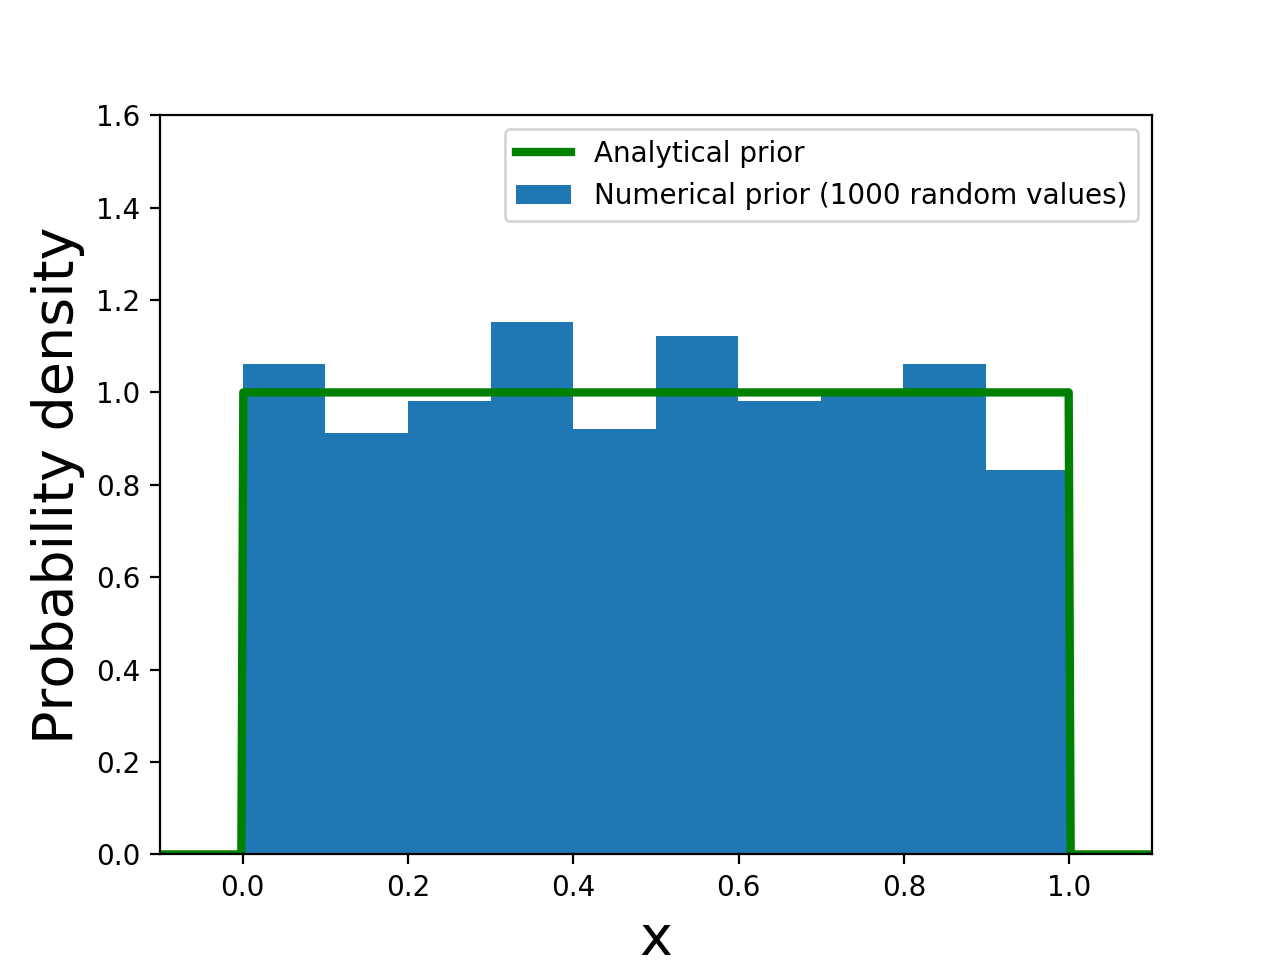

In [1]:
%matplotlib notebook

import numpy as np
from scipy import stats
from matplotlib import pyplot
import pymc

#construct an analytical prior:
x = np.linspace(-0.1, 1.1, 501)  #range of plausible x values, here expanded past 0 and 1 for visualization purposes
prior_analytical = stats.uniform.pdf(x)

#construct a numerical prior using PyMC:
nSamples = 1000  #number of random samples used to approximate x's distribution
x_stochastic = pymc.Uniform("MyPriorDistribution", 0, 1)  #stochastic variable representing our prior
prior_numerical = np.array( [x_stochastic.random()  for i in range(nSamples)] )

#plot the results:
pyplot.figure()
pyplot.hist(prior_numerical, density=True, label="Numerical prior (%d random values)" %nSamples)
pyplot.plot(x, prior_analytical, linewidth=3, color='g', label="Analytical prior")
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(0, 1.6)
pyplot.legend()
pyplot.xlabel('x', size=20)
pyplot.ylabel('Probability density', size=20);

The figure above depicts our prior both analytically and numerically. The analytical representation is a mathematical function:

\begin{equation}
    f(x)= 
    \begin{cases}
        1,& \text{if } 0 \leq x \leq 1\\
        0,& \text{otherwise}
    \end{cases}
\end{equation}


and based on this equation we can compute precise probabilities for *x*.  For example, the probability that *x* is between 0.2 and 0.5 is:

\begin{equation}
    P(0.2 \leq x \leq 0.5 ) = \int_{0.2}^{0.5} f(x) = 0.3
\end{equation}

We could instead regard the prior numerically, as a distribution of randomly sampled numbers, which approximates the analytical distribution.  While the analytical distribution is perfectly precise, the numerical distribution's accuracy depends on the number of samples (actual numerical values) we use to construct it.  The figure above uses 10,000 values, but if we were to use 1,000,000 values our approximation would be better as depicted below. 

<IPython.core.display.Javascript object>


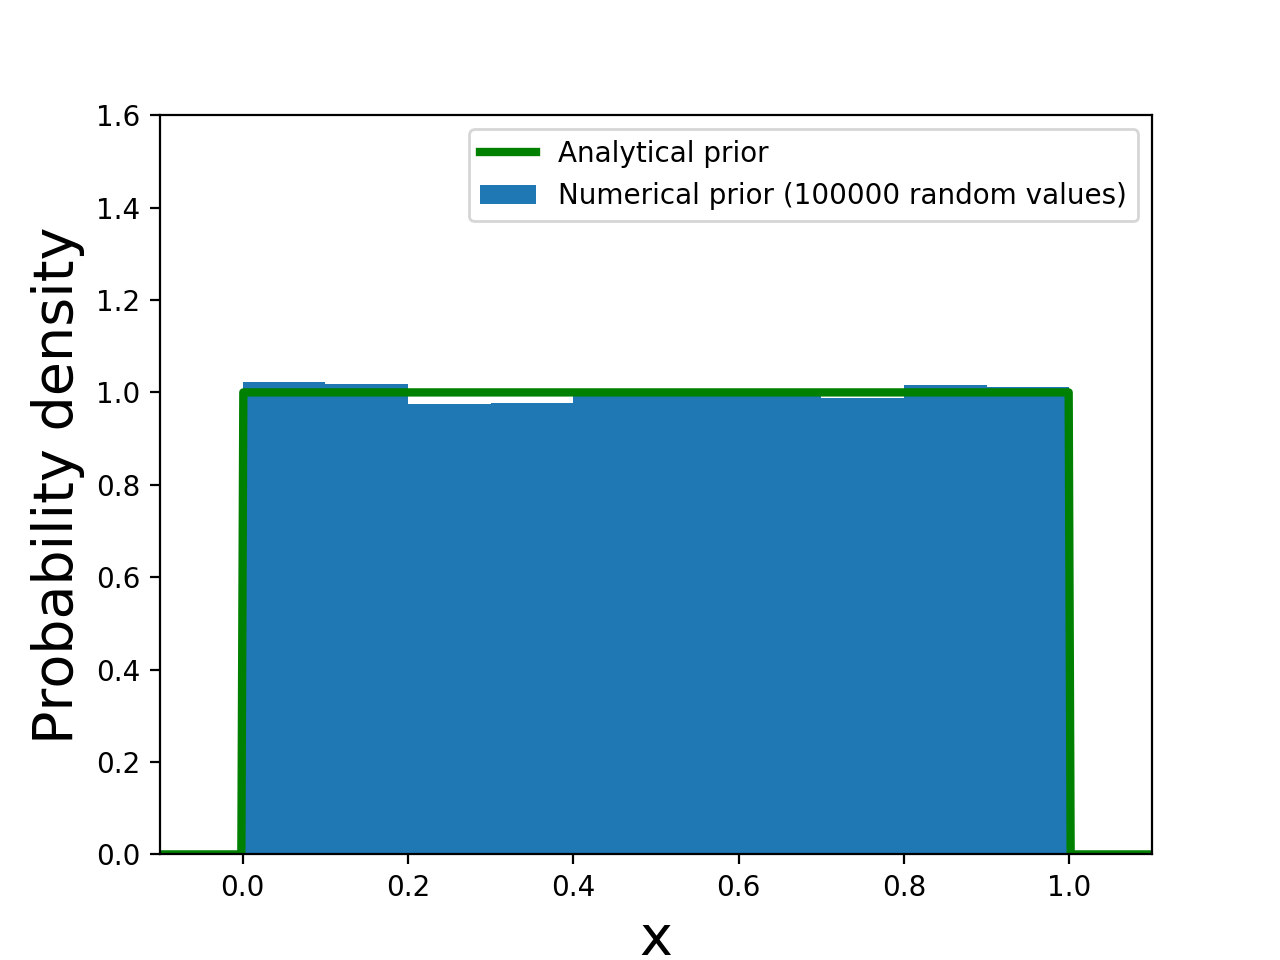

In [2]:
#construct a numerical prior using PyMC:
nSamples = 100000
prior_numerical = np.array( [x_stochastic.random()  for i in range(nSamples)] )

#plot the results:
pyplot.figure()
pyplot.hist(prior_numerical, density=True, label="Numerical prior (%d random values)" %nSamples)
pyplot.plot(x, prior_analytical, linewidth=3, color='g', label="Analytical prior")
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(0, 1.6)
pyplot.legend()
pyplot.xlabel('x', size=20)
pyplot.ylabel('Probability density', size=20);

This idea will reappear throughout this supplementary material:  the accuracy of a numerically estimated probability density improves as the number of samples gets larger. Since larger numerical samples require more computing resources, it is often important in Bayesian analysis to find a balance between sample size and accuracy.  This issue is addressed in Appendix X. For the remainder of this analysis we presume that 10,000 samples is accurate enough.

A final point regarding this prior, and probability distributions in general, is its most likely value. Even though our prior implies that all values of *x* are equally plausible, the most likely value of *x* is 0.5.

In [3]:
x_most_likely = prior_numerical.mean()
print( x_most_likely )

0.500135480575


This is termed the maximum likelihood estimate (MLE) of *x*.  To understand why the MLE is 0.5, simply think of an alternative value like 0.7. If the MLE were 0.7 it would imply that right ($x$=1) is more likely than left ($x$=0) and therefore that not all values of *x* (from 0 to 1) are equally likely.

Now that we have decided upon our prior distribution for *x*, we are ready to conduct our experiment and then update our beliefs regarding *x* based on the data we measure. Let's imagine first that we measure just a single subject and it turns out that this subject's right knee is stronger than their left knee. This observation can be represented as:

\begin{equation}
\newcommand{xobs}[]{ \ x_{\text{obs}} \ }
    x_{\text{obs}} = [ \ 1 \ ]
\end{equation}

How should we we update our beliefs regarding $x$ based on $\xobs$?  A skeptic might say we shouldn't change our beliefs based on a single observation. A Bayesian would say that we should update our beliefs according to Bayes' rule:


\begin{equation}
\newcommand{Right}[]{ \ \text{Right} \ }
    P( \ A \  | \xobs   )  = \frac{ P(  \xobs | \ A) P( \ A \ ) } {P (\xobs) }
\end{equation}

{NOTE TO SELF:   Bayes' rule requires an explanation}
 

Applying Bayes' rule to our observed data produces the following posterior: 

 [-----------------100%-----------------] 11000 of 11000 complete in 0.4 sec

<IPython.core.display.Javascript object>


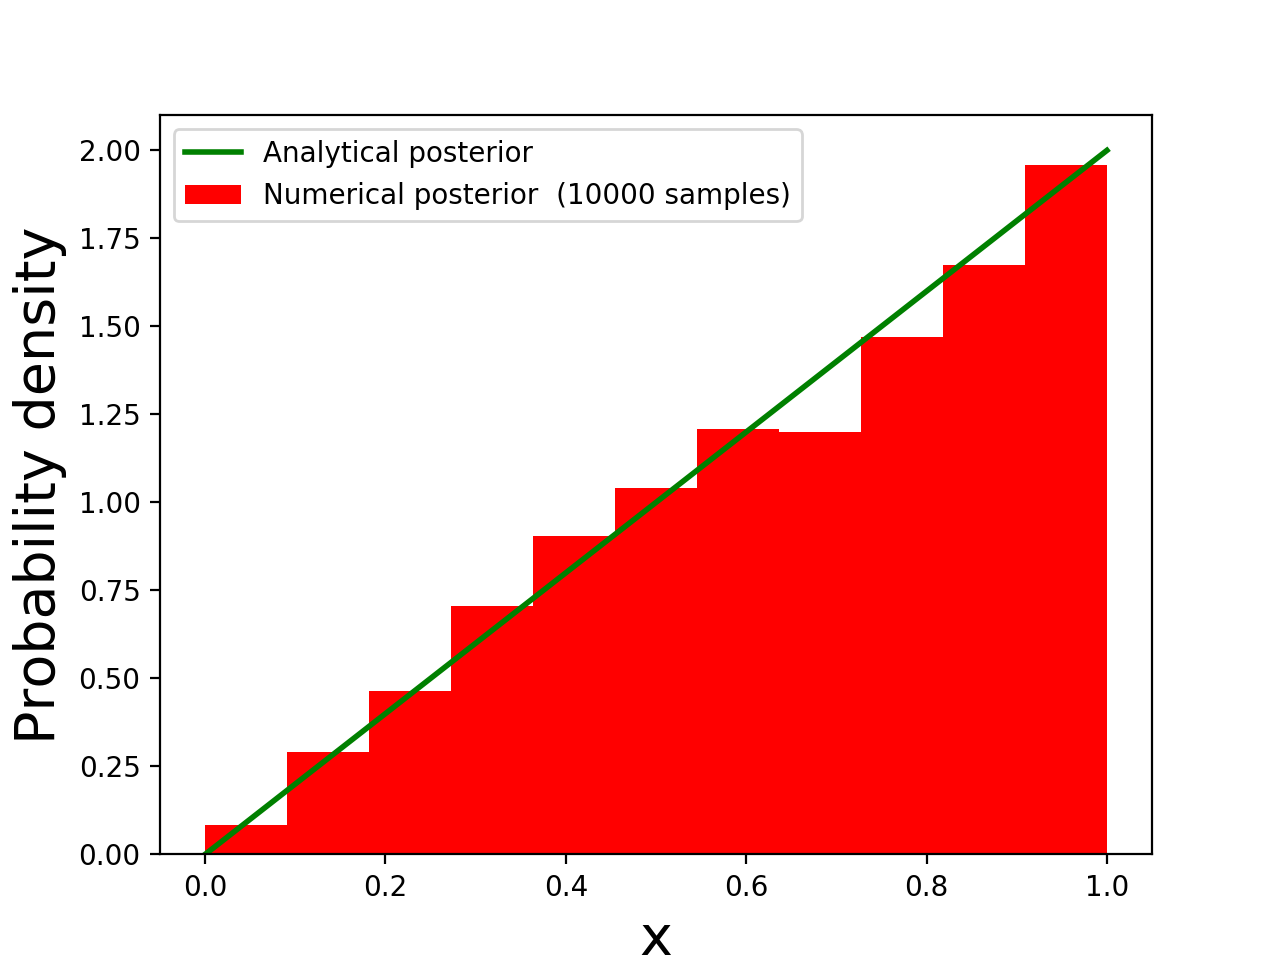

In [4]:
x_observed = [1]
n_observations = len(x_observed)
n_right_stronger = sum(x_observed)

# create a model of the experimental variables:
x = pymc.Uniform("x", lower=0, upper=1)  #prior distribition for x
y = pymc.Binomial("y", n=n_observations, p=x, value=n_right_stronger, observed=True) #model of experimental observations

# numerically fit the model to the data:
model = pymc.Model([x, y])
mcmc = pymc.MCMC(model)
nSamples = 10000
nBurn = 1000
mcmc.sample(nSamples+nBurn, nBurn)

#compute analytical posterior:
xx = np.linspace(0, 1, 21)
posterior_analytical = stats.beta.pdf(xx, n_observations+1, n_observations - n_right_stronger + 1)

# check results:
posterior = mcmc.trace("x")[:]  #numerical posterior
pyplot.figure()
pyplot.hist(posterior, density=True, range=(0,1), bins=11, facecolor="r", label="Numerical posterior  (%d samples)" %nSamples)
pyplot.plot(xx, posterior_analytical, 'g', lw=2, label="Analytical posterior")
pyplot.legend(loc="upper left")
pyplot.xlabel('x', size=20)
pyplot.ylabel('Probability density', size=20);

Bayes' rule has changed the shape of our prior distribution into the posterior distribution depicted above. According to Bayes' rule, we should no longer believe that all values of *x* are equally plausible.  Instead we should believe that *x*=1 is more likely than *x*=0, and that *x*'s most likely value is 0.67.  Note that, like the prior distribution, the total area under the posterior curve is one.  This means that the probability that $x$ is between 0 and 1 is 100%.

In [5]:
x_most_likely = posterior.mean()
print( x_most_likely )

0.659363282929


<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>**NOTE:**</p>
<p>Understanding the posterior's analytical derivation is not essential for understanding how Bayesian analysis actually works. For more complex priors and/or for more complex data models it is cumbersome or even impossible to compute posteriors analytically.  To avoid those complexities this Appendix discusses only the numerical approach, but presents the analytical results in the figures as a reference. Readers interested in analytical solutions should consult textbooks like (REFERENCE).
</p>
</div>

This analysis represents a conceptual departure from classical null hypothesis testing (NHT).  NHT requires variance estimates (usually as standard deviations), and thus multiple observations, but the Bayesian approach can operate on a single observation. This is made possible by our specification of a prior, which implicitly embodies variance.

The prior can be thought of as a compliant 1D surface, in this case a perfectly flat surface, and our observation ($x$=1) can be thought of as a peg that pokes the surface upward at that point, dragging the rest of the surface with it to retain a total area of one. 

This raises an unsettling question, and an important limitation of Bayesian analysis:  *what if we had specified a different prior distribution?* That is an important question to which we will momentarily return. First let's consider what happens with multiple observations.

Imagine that we measured four more subjects, all who exhibit a stronger right than left knee. What does our posterior look like now?

 [-----------------100%-----------------] 11000 of 11000 complete in 0.3 sec

<IPython.core.display.Javascript object>


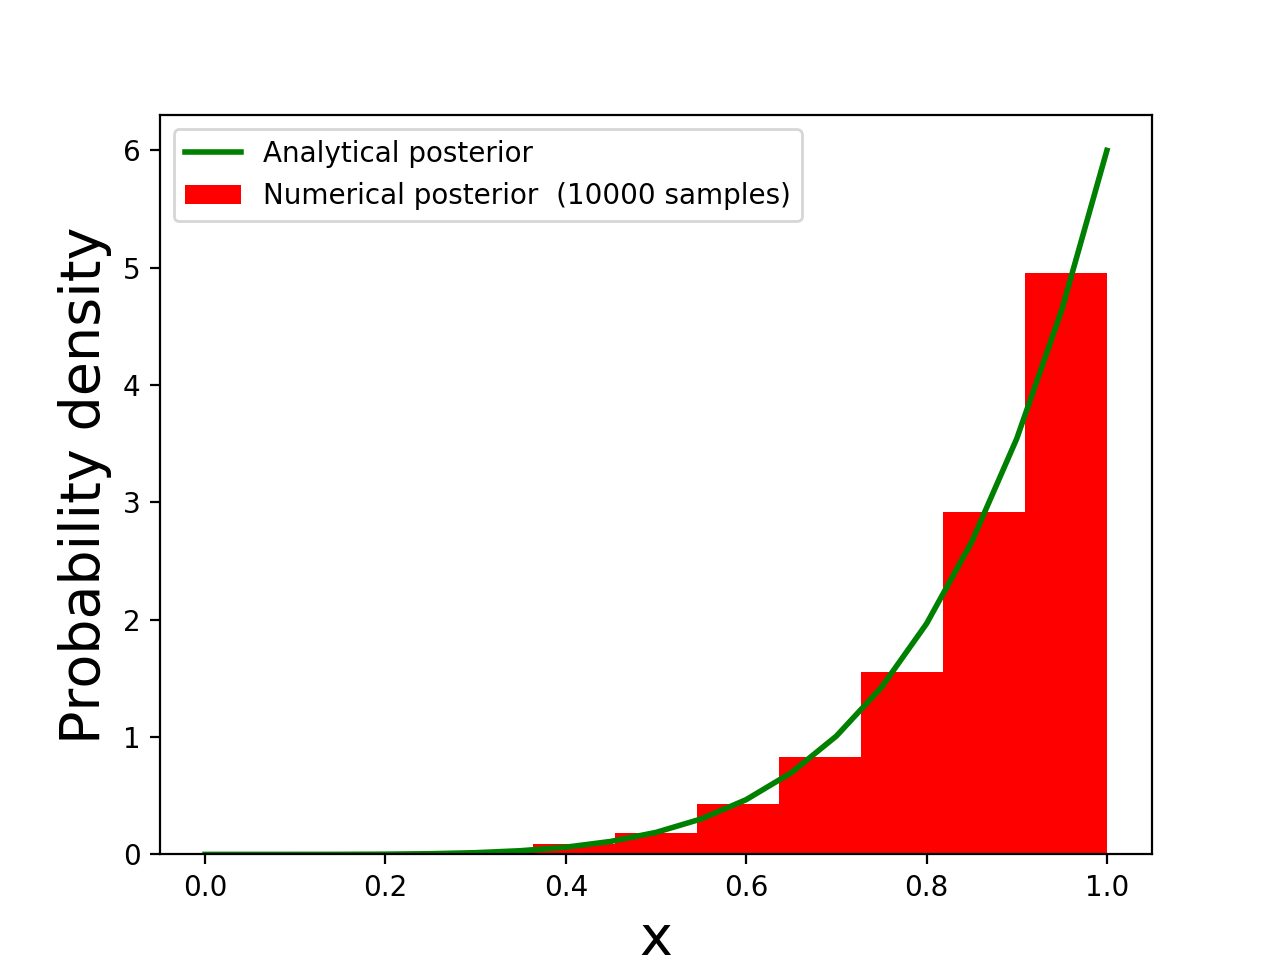

In [6]:
x_observed = [1, 1, 1, 1, 1]
n_observations = len(x_observed)
n_right = sum(x_observed)
n_left = n_observations - n_right

# create a model of the experimental variables:
x = pymc.Uniform("x", lower=0, upper=1)  #prior distribition for x
y = pymc.Binomial("y", n=n_observations, p=x, value=n_right, observed=True) #model of experimental observations

# numerically fit the model to the data:
model = pymc.Model([x, y])
mcmc = pymc.MCMC(model)
mcmc.sample(11000, 1000)

#compute analytical posterior:
xx = np.linspace(0, 1, 21)
posterior_analytical = stats.beta.pdf(xx, n_right+1, n_left+1)
# check results:
posterior = mcmc.trace("x")[:]  #numerical posterior
pyplot.figure()
pyplot.hist(posterior, density=True, range=(0,1), bins=11, facecolor="r", label="Numerical posterior  (%d samples)" %nSamples)
pyplot.plot(xx, posterior_analytical, 'g', lw=2, label="Analytical posterior")
pyplot.legend(loc="upper left")
pyplot.xlabel('x', size=20)
pyplot.ylabel('Probability density', size=20);

Our posterior is now biased even more toward $x$=1, reflecting our updated belief that the true value of $x$ is likely 1 or close to it. This posterior implies that the probability that $x$'s true value is zero is very small, and indeed that all values less than 0.5 are quite unlikely. We can compute the probability that $x$'s true value is less than 0.5 as:

In [7]:
b = posterior < 0.5     #binary vector containing ones where posterior is less than 0.5, and zeros elsewhere
s = sum(b)              #total number of values less than 0.5
p = float(s) / nSamples #proportion of values less than 0.5 
print( p )

0.0193


Or more briefly as:

In [8]:
p = (posterior < 0.5).mean()
print( p )

0.0193


In the calculations we can see another important departure from classical NHT. Whereas NHT usually involves a single result: a test statistic and associated p value, Bayesian posteriors allow for much more flexible data-relevant questions. One examples is: *what is the probability that $x$ is not between 0.4 and 0.6?*  That question is very data-relevant, and is also not readily addressible using NHT. With Bayesian analysis the answer can easily be calculated from the posterior:

In [9]:
p = ( (posterior < 0.4) | (posterior > 0.6) ).mean()
print( p )

0.956


Before returning to the issue of how the prior affects the posterior, let's consider how different datasets affect the posterior.


<IPython.core.display.Javascript object>


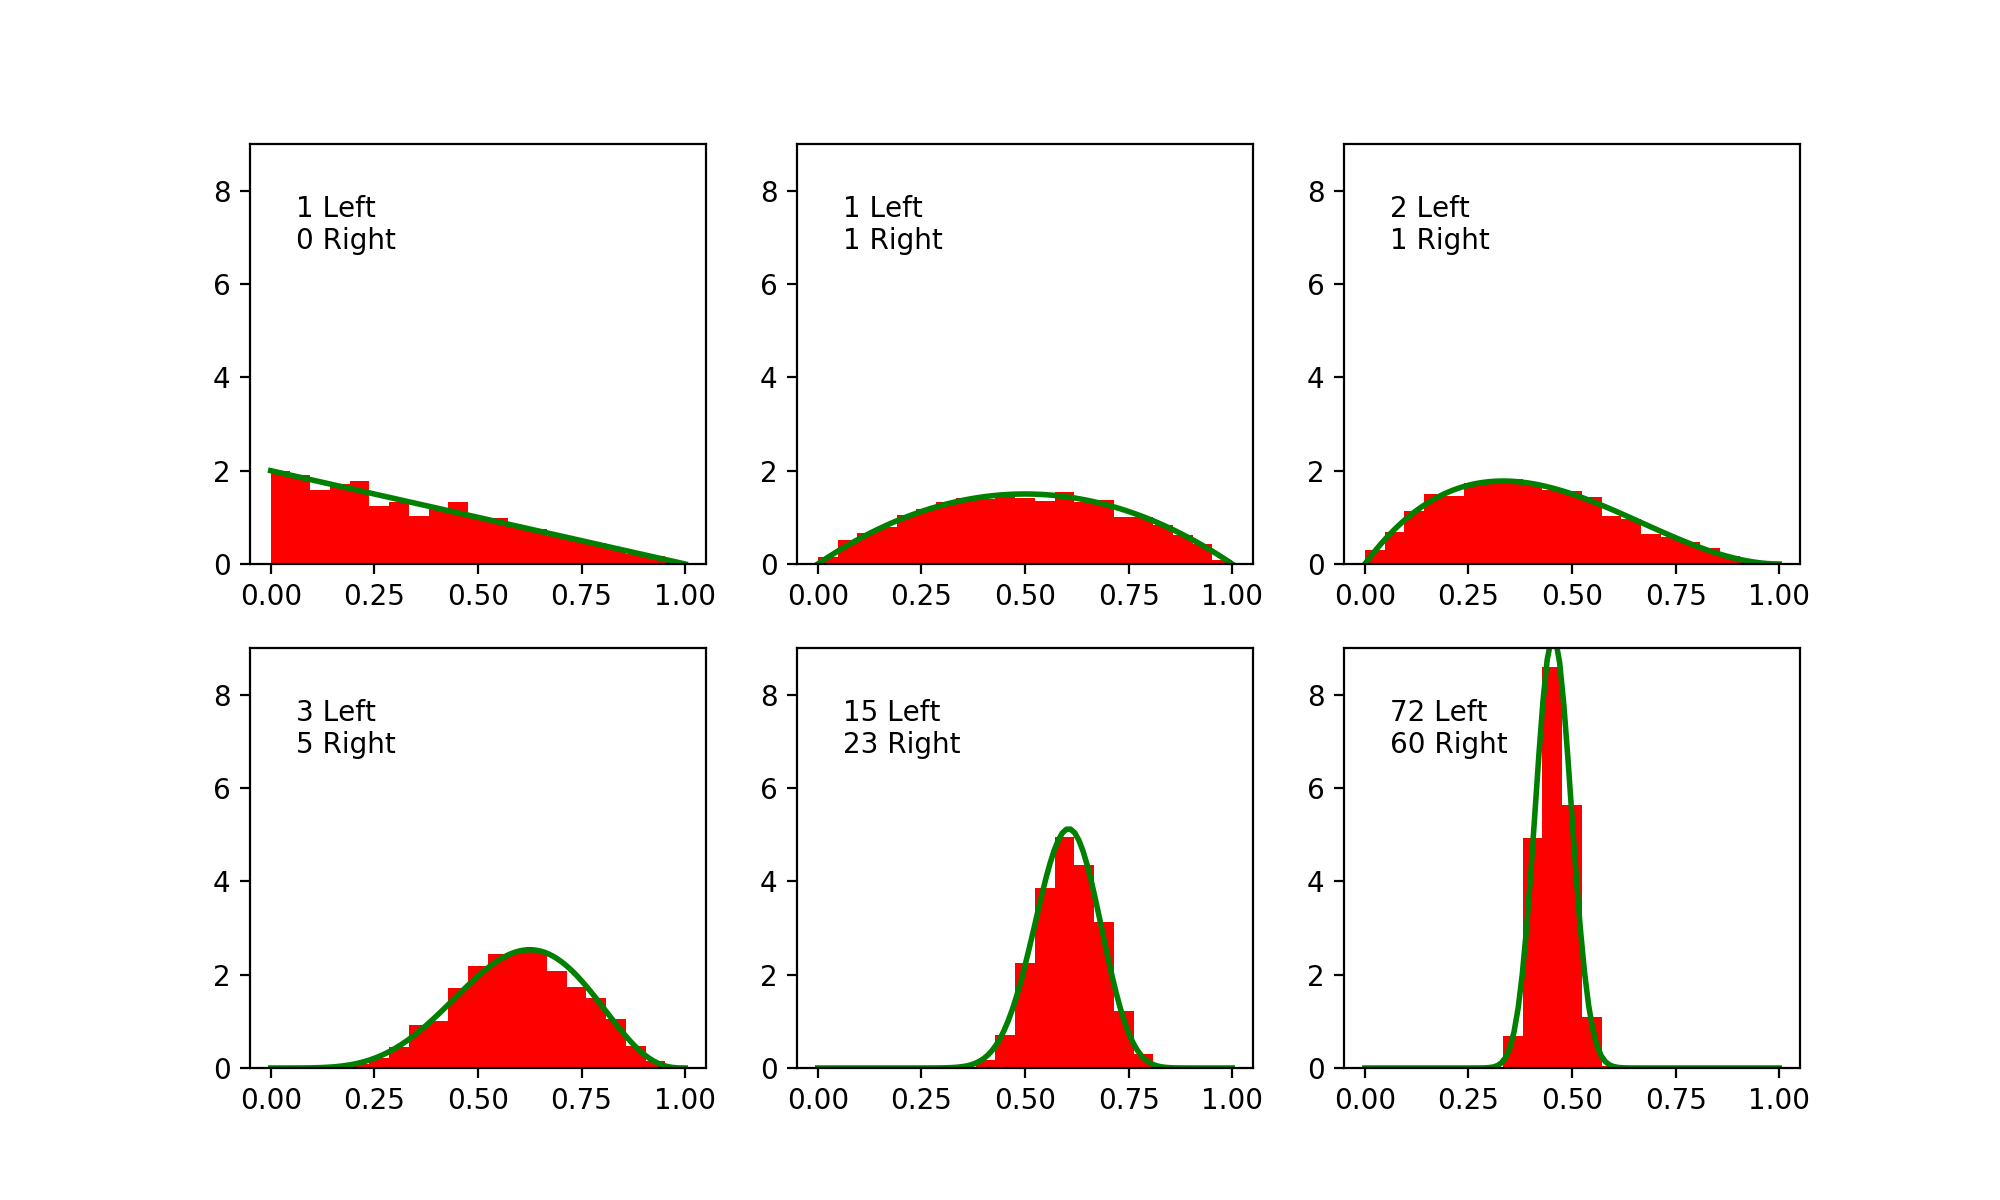

 [-----------------100%-----------------] 11000 of 11000 complete in 0.3 sec

In [10]:
#create six different datasets
X_OBSERVED = []
X_OBSERVED.append( [0] )
X_OBSERVED.append( [1, 0] )
X_OBSERVED.append( [1, 0, 0] )
X_OBSERVED.append( [1]*5 + [0]*3 )  #5 ones and 3 zeros
X_OBSERVED.append( [1]*23 + [0]*15 )  #23 ones and 15 zeros
X_OBSERVED.append( [1]*60 + [0]*72 )    #60 ones and 72 zeros


pyplot.figure(figsize=(10, 6))


for i,x_observed in enumerate(X_OBSERVED):
    n_observations = len(x_observed)
    n_right = sum(x_observed)
    n_left = n_observations - n_right

    # create a model of the experimental variables:
    x = pymc.Uniform("x", lower=0, upper=1)  #prior distribition for x
    y = pymc.Binomial("y", n=n_observations, p=x, value=n_right, observed=True) #model of experimental observations

    # numerically fit the model to the data:
    model = pymc.Model([x, y])
    mcmc  = pymc.MCMC(model)
    mcmc.sample(11000, 1000)

    #compute analytical posterior:
    xx = np.linspace(0, 1, 101)
    posterior_analytical = stats.beta.pdf(xx, n_right+1, n_left+1)
    
    # check results:
    posterior = mcmc.trace("x")[:]  #numerical posterior
    ax = pyplot.subplot(2,3,i+1)
    ax.hist(posterior, density=True, range=(0,1), bins=21, facecolor="r")
    ax.plot(xx, posterior_analytical, 'g', lw=2, label="Analytical posterior")
    ax.set_ylim(0, 9)
    ax.text(0.1, 0.75, '%d Left\n%d Right' %(n_left, n_right), transform=ax.transAxes)

In the figure above we can see that:

* As the number of observations increases, we become increasingly confident that we are honing in on $x$'s true value.
* We retain uncertainty, even for relatively large datasets.
* We never completely dismiss the possibility that $x$'s true value can be anywhere between 0 and 1.
* We can compute arbitrary probabilities, based on the observed data, regarding where along the 0-to-1 range $x$'s true value lies. 

Now let's return to the issue of the prior, and how it affects the posterior. Let's first consider just a single "Right" observation and then compare the previous flat (uniform) prior to two different normal priors.

<IPython.core.display.Javascript object>


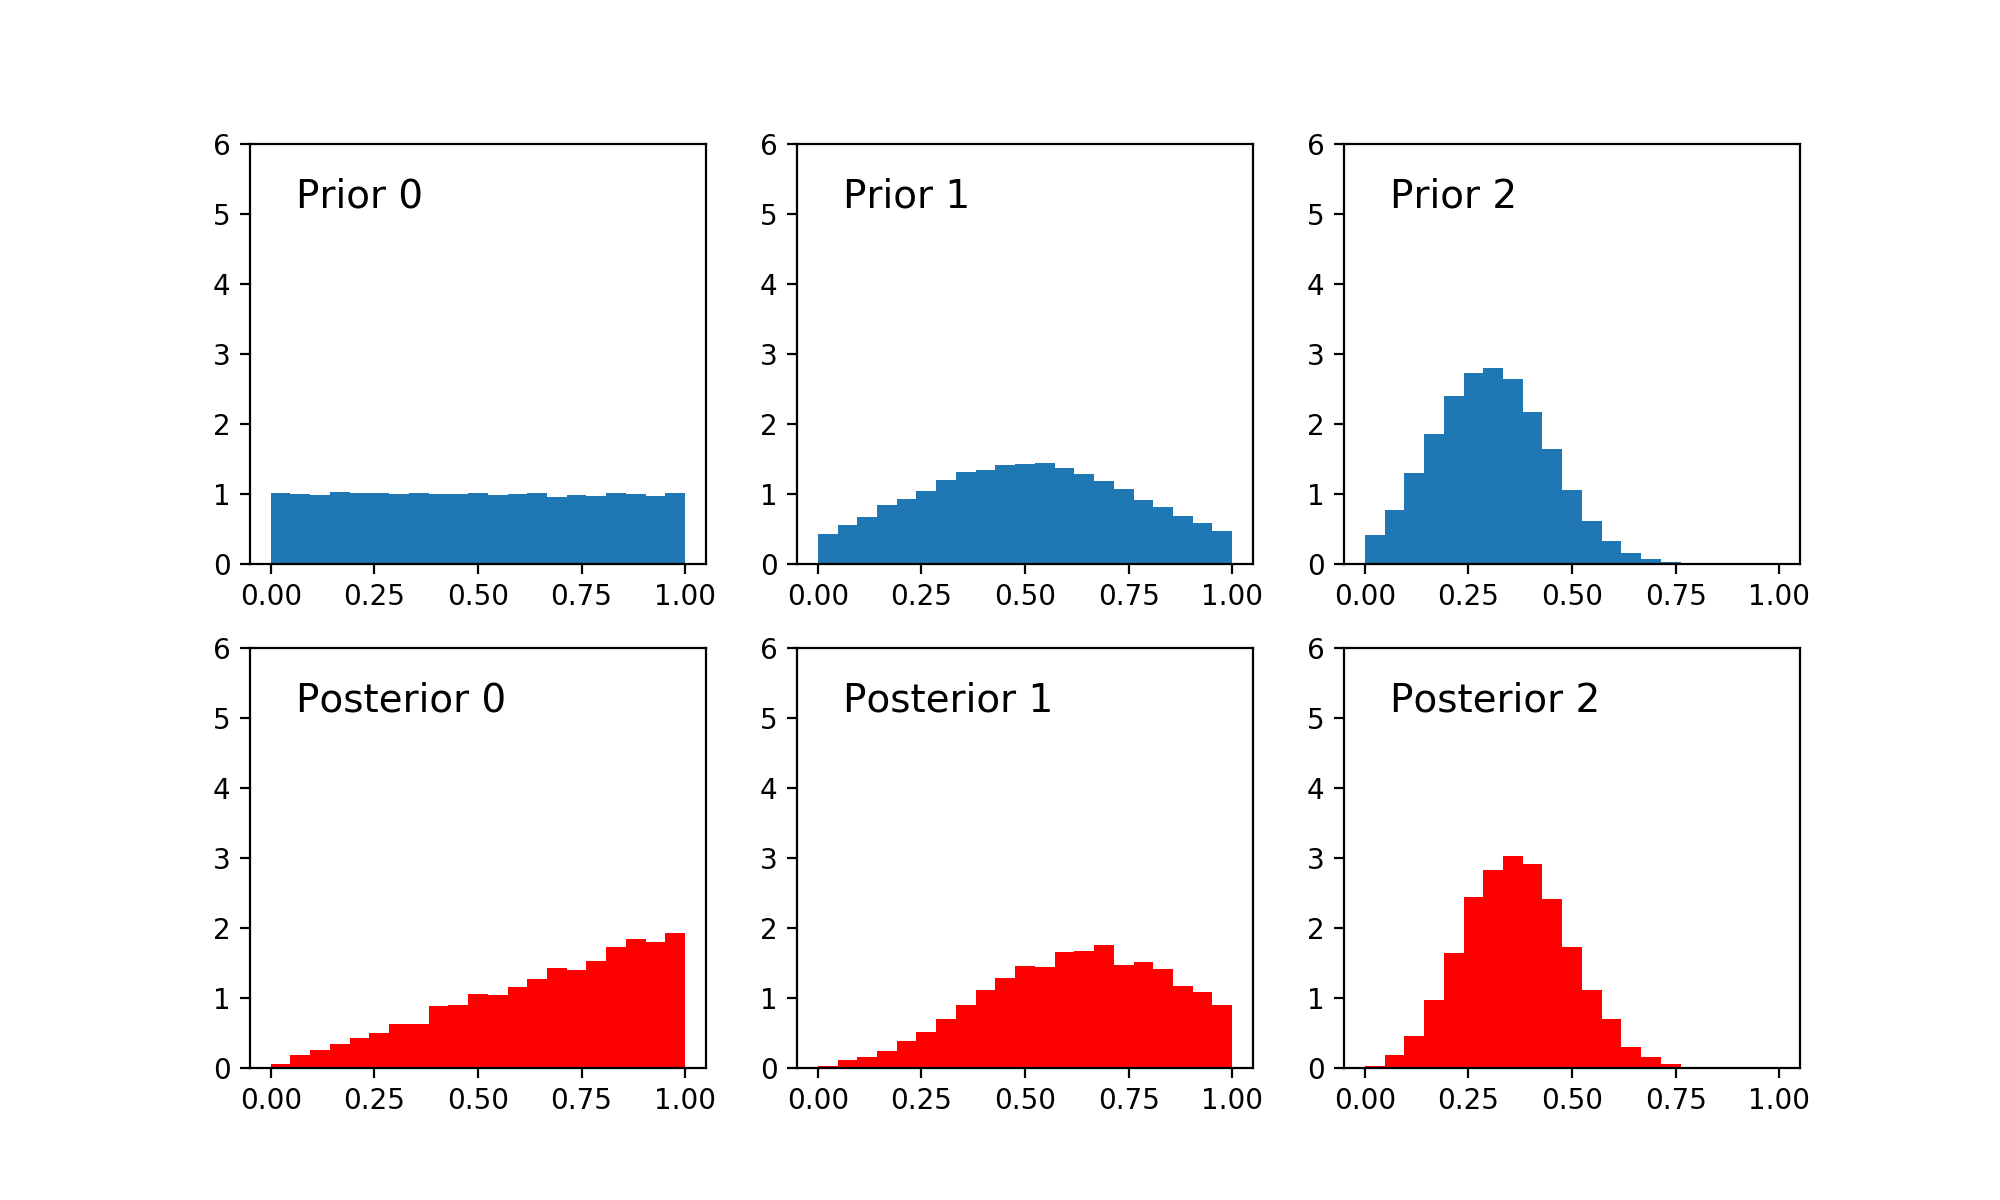

 [-----------------100%-----------------] 51000 of 51000 complete in 1.5 sec

In [11]:
x_observed = [1]
n_observations = len(x_observed)
n_right = sum(x_observed)
n_left = n_observations - n_right

# create three different priors:
x0 = pymc.Uniform("x", lower=0, upper=1)
x1 = pymc.Normal("x", mu=0.5, tau=10)
x2 = pymc.Normal("x", mu=0.3, tau=50)

pyplot.figure(figsize=(10,6))

for i,x in enumerate([x0,x1,x2]):
    y     = pymc.Binomial("y", n=1, p=x, value=1, observed=True) #model of experimental observations
    model = pymc.Model([x, y])
    mcmc  = pymc.MCMC(model)
    mcmc.sample(51000, 10000)
    
    prior     = [x.random() for ii in range(50000)]  #numerically sampled prior distribution
    posterior = mcmc.trace("x")[:]  #numerical posterior
    ax = pyplot.subplot(2,3,i+1)
    ax.hist(prior, density=True, range=(0,1), bins=21)
    ax.set_ylim(0, 6)
    ax.text(0.1, 0.85, 'Prior %d' %i, transform=ax.transAxes, size=14)

    ax = pyplot.subplot(2,3,i+4)
    ax.hist(posterior, density=True, range=(0,1), bins=21, facecolor="r")
    ax.set_ylim(0, 6)
    ax.text(0.1, 0.85, 'Posterior %d' %i, transform=ax.transAxes, size=14)

From these results we notice that single observations have a substantial effect on flat priors, but contrastingly little effect on narrow priors. In other words, the prior distribution's narrowness reflects our confidence, and this confidence is not easily shaken by a single observation.

Let's now look at what happens when we use the exact same priors, but with a larger dataset consisting of 20 Left and 30 Right observations.

<IPython.core.display.Javascript object>


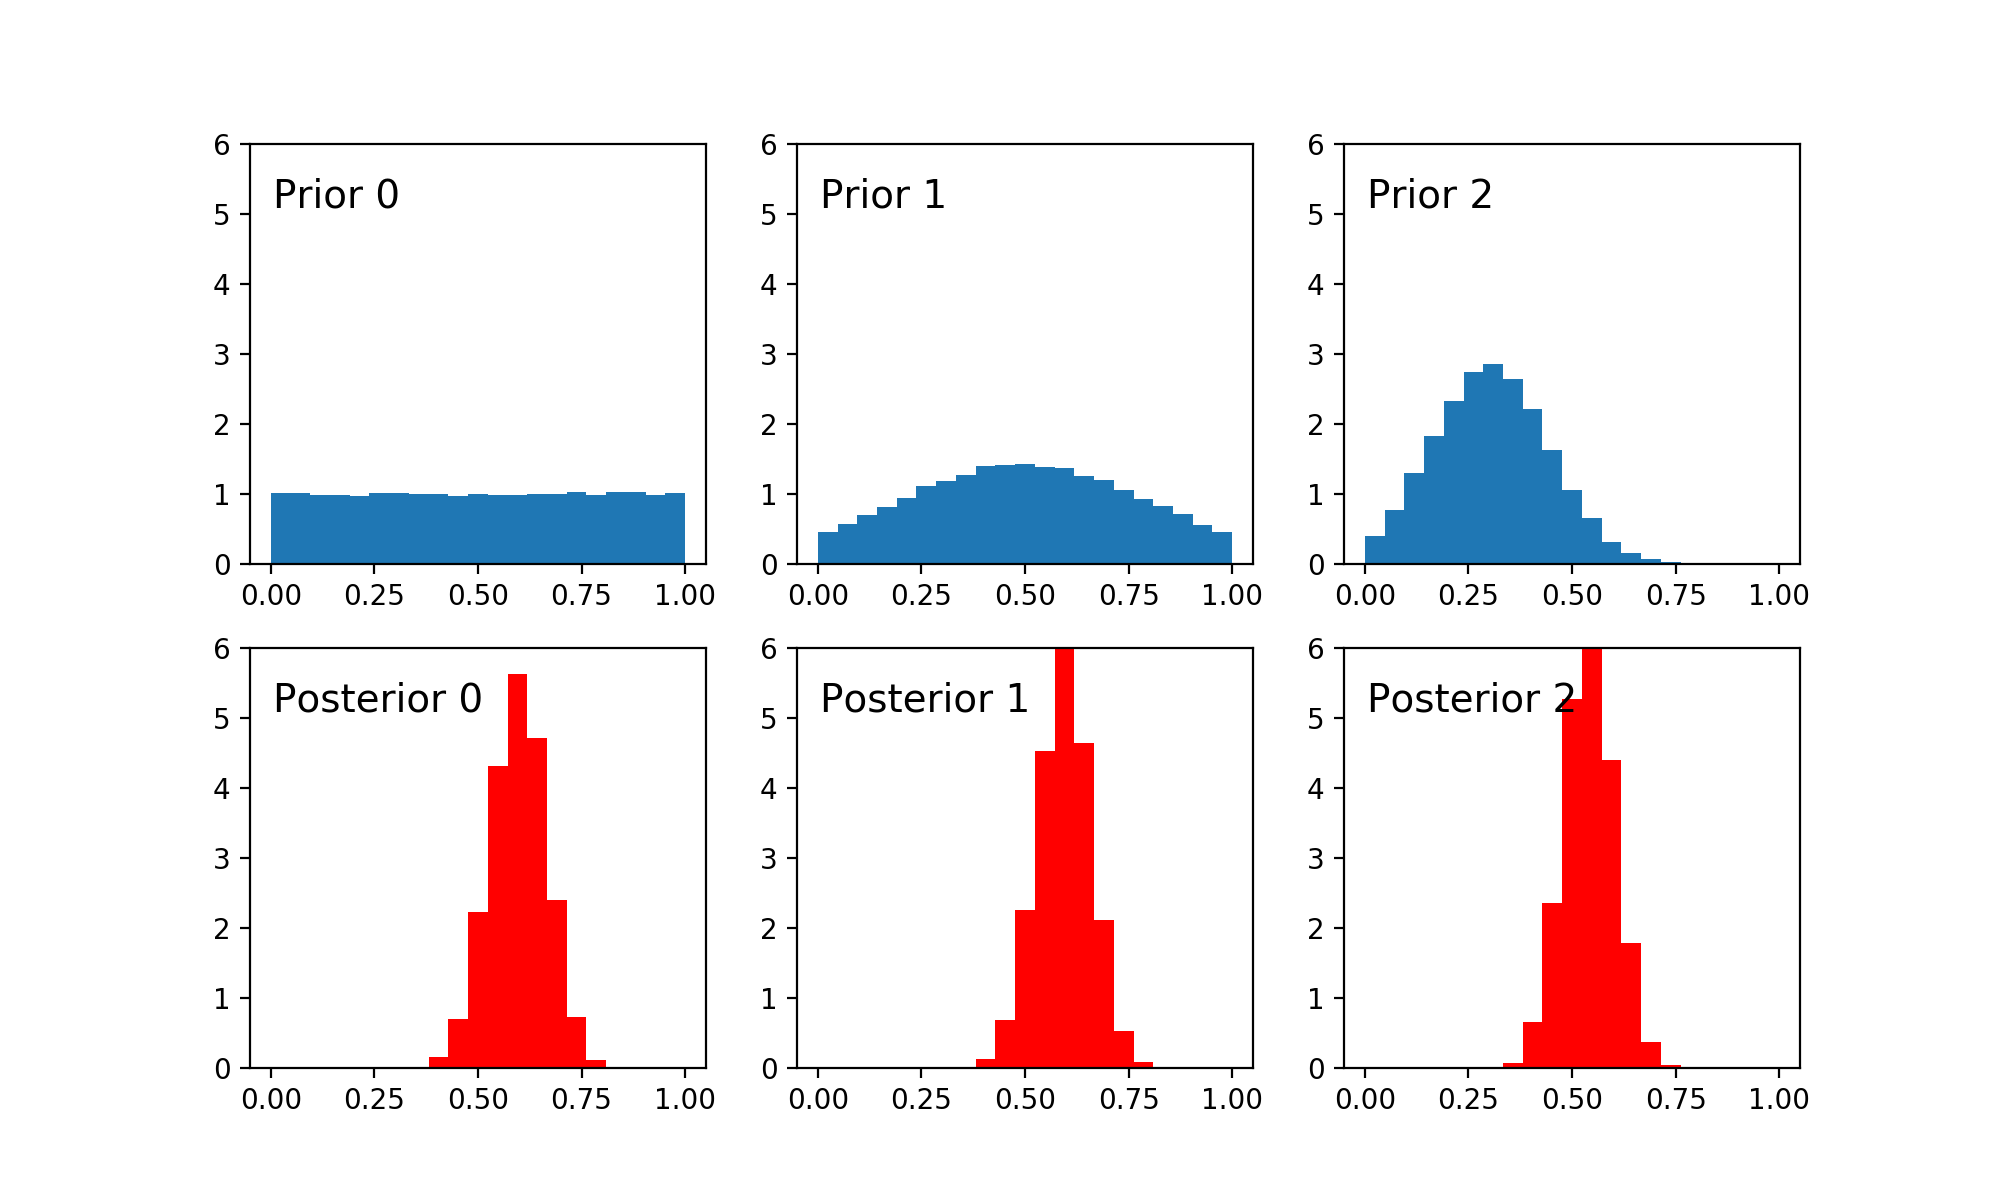

 [-----------------100%-----------------] 51000 of 51000 complete in 2.0 sec

In [12]:
x_observed = [0]*20 + [1]*30
n_observations = len(x_observed)
n_right = sum(x_observed)
n_left = n_observations - n_right

# create three different priors:
x0 = pymc.Uniform("x", lower=0, upper=1)
x1 = pymc.Normal("x", mu=0.5, tau=10)
x2 = pymc.Normal("x", mu=0.3, tau=50)

pyplot.figure(figsize=(10,6))

for i,x in enumerate([x0,x1,x2]):
    y     = pymc.Binomial("y", n=n_observations, p=x, value=n_right, observed=True) #model of experimental observations
    model = pymc.Model([x, y])
    mcmc  = pymc.MCMC(model)
    mcmc.sample(51000, 10000)
    
    prior     = [x.random() for ii in range(50000)]  #numerically sampled prior distribution
    posterior = mcmc.trace("x")[:]  #numerical posterior
    ax = pyplot.subplot(2,3,i+1)
    ax.hist(prior, density=True, range=(0,1), bins=21)
    ax.set_ylim(0, 6)
    ax.text(0.05, 0.85, 'Prior %d' %i, transform=ax.transAxes, size=14)

    ax = pyplot.subplot(2,3,i+4)
    ax.hist(posterior, density=True, range=(0,1), bins=21, facecolor="r")
    ax.set_ylim(0, 6)
    ax.text(0.05, 0.85, 'Posterior %d' %i, transform=ax.transAxes, size=14)

These results show that, irrespective of the prior, our beliefs converge to approximately the same posterior distribution. In other words, Bayes' rule permits a relatively large amount of data to objectively sway our prior beliefs in a data-driven manner, whatever those prior beliefs may be.

The issue of the prior-dependendent posteriors is thus applicable primarily to small datasets.  There are objective ways for selecting priors, but that discussion is beyond the scope of this paper.  Like above the main paper considers a variety of priors and then qualitatively compares the posteriors. 

## REFERENCES

Darwiche A. (2009). *Modeling and reasoning with Bayesian networks*. Cambridge University Press.

Davidson-Pilon C (2015). *Probabilistic Programming & Bayesian Methods for Hackers*. Addison-Wesley Professional.

Patil A, Huard D, Fonnesbeck CJ (2010). PyMC: Bayesian stochastic modelling in Python. *Journal of Statistical Software* 35(4): 1.